# Compare climate model dataset simulated values with measured averages - HiResIreland

In [1]:
import importlib
import os

from datetime import datetime, timezone

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats

import climag.plot_configs as cplt
import climag.plot_stats as cstats
from itertools import product

In [2]:
ie_bbox = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="ne_10m_land_2157_IE_BBOX_DIFF",
)

In [3]:
data = cstats.hist_rcp_stats_data(
    dataset="HiResIreland", stat="mean", diff=False
)["HiResIreland_s"].drop_vars(["bm", "sen_abs", "c_bm", "pgro"])

In [4]:
data

<xarray.Dataset>
Dimensions:      (rlon: 90, rlat: 116, exp: 3, model: 4, season: 4)
Coordinates:
  * rlon         (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat         (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
  * exp          (exp) object 'historical' 'rcp45' 'rcp85'
  * model        (model) object 'CNRM-CM5' 'EC-EARTH' 'HadGEM2-ES' 'MPI-ESM-LR'
  * season       (season) object 'DJF' 'MAM' 'JJA' 'SON'
    lon          (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat          (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    spatial_ref  int64 0
Data variables:
    gro          (season, model, exp, rlat, rlon) float64 dask.array<chunksize=(4, 1, 1, 116, 90), meta=np.ndarray>

In [5]:
data_crs = data.rio.crs

In [6]:
counties = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="OSi_OSNI_IE_Counties_2157",
)
counties["COUNTY"] = counties["COUNTY"].str.title()
counties.set_index("COUNTY", inplace=True)

In [8]:
counties

,CONTAE,PROVINCE,geometry
COUNTY,,,
Donegal,Dún na nGall,Ulster,"MULTIPOLYGON (((668515.913 943718.890, 668514...."
Limerick,Luimneach,Munster,"POLYGON ((565662.328 665775.167, 565663.255 66..."
Kildare,Cill Dara,Leinster,"POLYGON ((700193.727 734740.683, 700202.676 73..."
Waterford,Port Láirge,Munster,"MULTIPOLYGON (((627774.638 593971.494, 627777...."
Dublin,Baile Átha Cliath,Leinster,"MULTIPOLYGON (((730410.012 750574.906, 730401...."
Westmeath,An Iarmhí,Leinster,"POLYGON ((641367.591 732152.211, 641366.980 73..."
Monaghan,Muineachán,Ulster,"MULTIPOLYGON (((675985.454 835478.726, 676014...."
Wicklow,Cill Mhantáin,Leinster,"MULTIPOLYGON (((725064.152 671911.669, 725060...."
Cork,Corcaigh,Munster,"MULTIPOLYGON (((539837.098 620406.502, 539820...."


In [9]:
ts = pd.read_csv(os.path.join("data", "grass_growth", "average_growth.csv"))
ts.set_index("county", inplace=True)

In [10]:
ts

,MAM,JJA,All seasons
county,,,
Clare,33.971692,59.245682,35.069927
Cavan,34.705191,63.107348,36.133354
Sligo,34.715891,61.773817,37.228315
Mayo,35.212769,62.927955,37.632832
Roscommon,36.365447,59.057787,38.051232
Monaghan,36.961679,63.546970,38.752225
Kerry,37.546769,63.960152,38.356859
Donegal,38.011129,67.717863,42.294269
Limerick,38.163206,59.864167,36.001764


In [28]:
ts_2018 = pd.read_csv(
    os.path.join("data", "grass_growth", "average_growth_2018.csv")
)
ts_2018.set_index("county", inplace=True)

In [29]:
ts_2018

,2018 (MAM),2018 (JJA),2018
county,,,
Cavan,33.308462,58.839231,33.296600
Sligo,34.044615,58.590769,35.042553
Mayo,34.106923,56.314615,32.167000
Roscommon,35.227692,60.436154,36.075208
Monaghan,37.160769,58.309231,37.622000
Donegal,37.260833,67.670000,39.279773
Clare,37.481538,54.420769,34.726275
Limerick,37.493846,42.010000,29.871038
Carlow,38.603077,34.856923,29.011961


In [11]:
data_county = {}
for county in ts.index:
    data_county[county] = data.rio.clip(
        counties.loc[[county]].to_crs(data_crs)["geometry"], all_touched=True
    )

In [31]:
data_county_mam = data_county.copy()

for key in data_county_mam.keys():
    data_county_mam[key] = data_county_mam[key].sel(season="MAM")
    data_county_mam[key] = data_county_mam[key].assign(
        gro_diff=data_county_mam[key]["gro"] - ts.loc[county]["MAM"]
    )
    data_county_mam[key] = data_county_mam[key].assign(
        gro_diff_2018=(
            data_county_mam[key]["gro"] - ts_2018.loc[county]["2018 (MAM)"]
        )
    )

data_county_mam = xr.merge(data_county_mam.values())

In [32]:
data_county_jja = data_county.copy()

for key in data_county_jja.keys():
    data_county_jja[key] = data_county_jja[key].sel(season="JJA")
    data_county_jja[key] = data_county_jja[key].assign(
        gro_diff=data_county_jja[key]["gro"] - ts.loc[county]["JJA"]
    )
    data_county_jja[key] = data_county_jja[key].assign(
        gro_diff_2018=(
            data_county_jja[key]["gro"] - ts_2018.loc[county]["2018 (JJA)"]
        )
    )

data_county_jja = xr.merge(data_county_jja.values())

In [43]:
def data_plot(data, var, levels=None, ticks=None):
    fig = data[var].plot.contourf(
        x="rlon",
        y="rlat",
        transform=cplt.rotated_pole_transform(data),
        subplot_kws={"projection": cplt.projection_hiresireland},
        cmap="BrBG",
        col="model",
        row="exp",
        xlim=(-1.9, 1.6),
        ylim=(-2.1, 2.1),
        extend="both",
        figsize=(12, 13.75),
        levels=levels,
        cbar_kwargs={
            "ticks": ticks,
            "aspect": 30,
            "location": "bottom",
            "fraction": 0.085,
            "shrink": 0.85,
            "pad": 0.05,
            "extendfrac": "auto",
            "label": "Difference [kg DM ha⁻¹ day⁻¹]",
        },
    )
    for (col, model), (row, exp) in product(
        enumerate(data["model"].values), enumerate(data["exp"].values)
    ):
        ie_bbox.to_crs(cplt.projection_hiresireland).plot(
            ax=fig.axs[row][col],
            edgecolor="darkslategrey",
            color="white",
            linewidth=0.5,
        )
    fig.set_titles("{value}", weight="semibold", fontsize=14)
    plt.show()

## Compare growth with seasonal averages

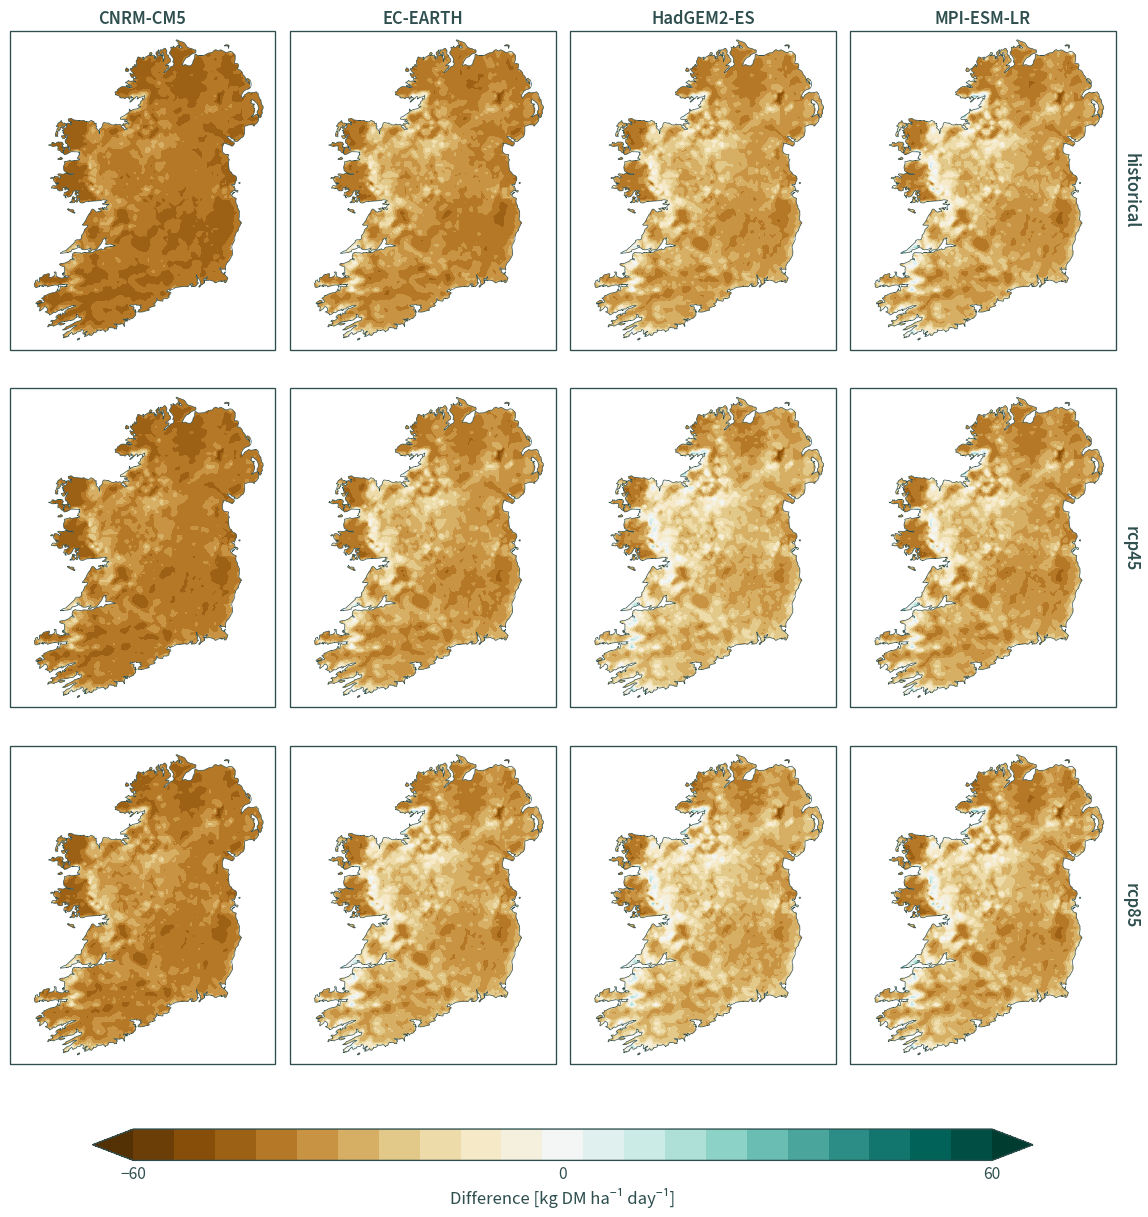

In [41]:
data_plot(
    data_county_mam,
    "gro_diff",
    cstats.colorbar_levels(60),
    cstats.colorbar_ticks(60),
)

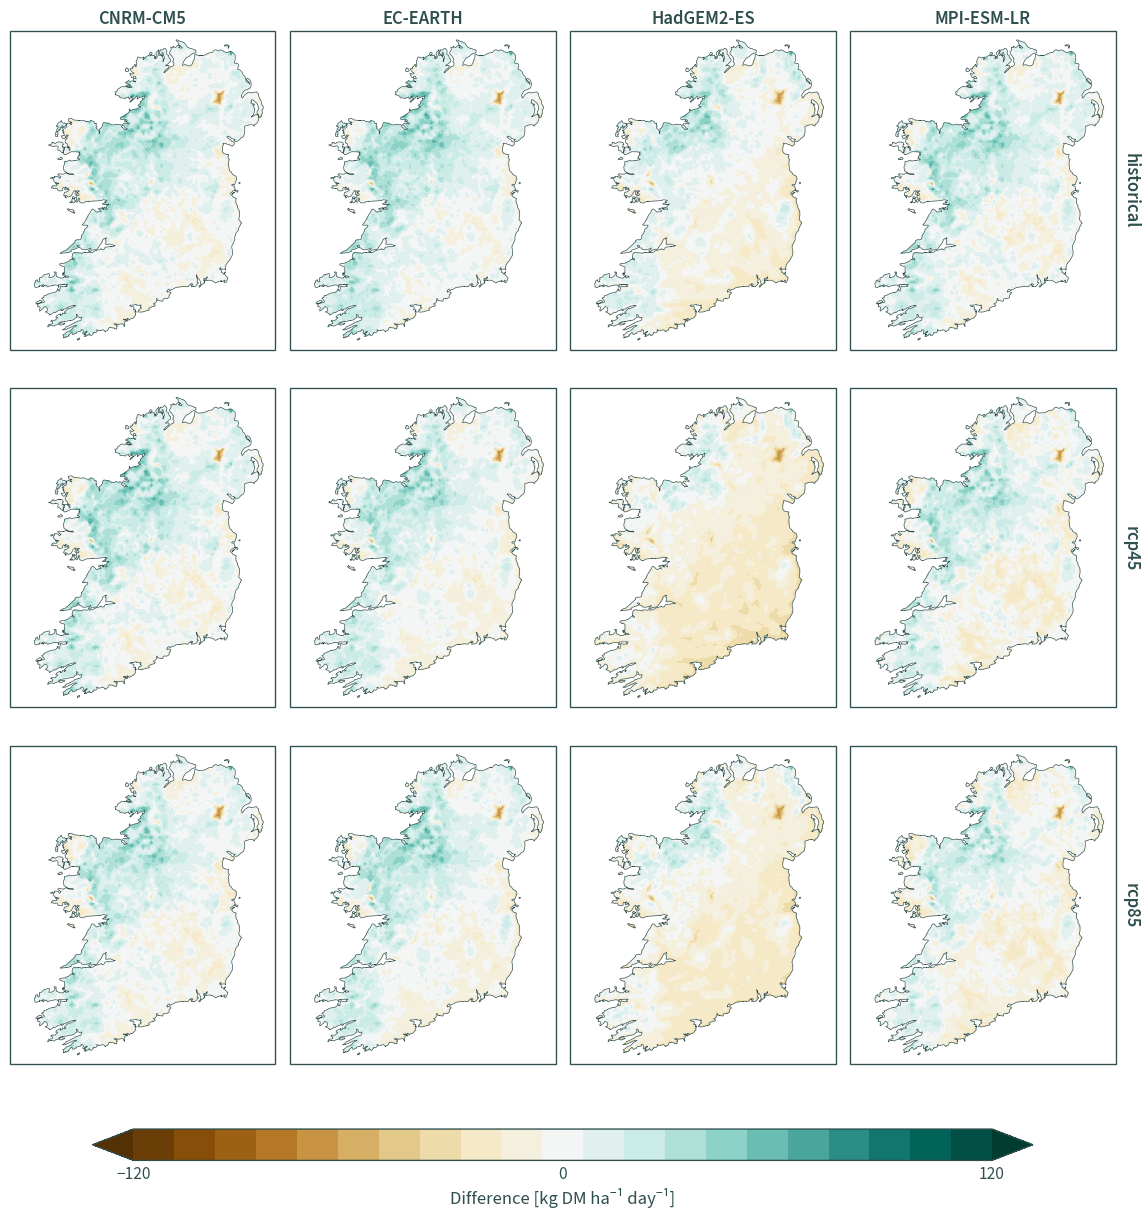

In [42]:
data_plot(
    data_county_jja,
    "gro_diff",
    cstats.colorbar_levels(120),
    cstats.colorbar_ticks(120),
)

## Compare growth with 2018 seasonal averages

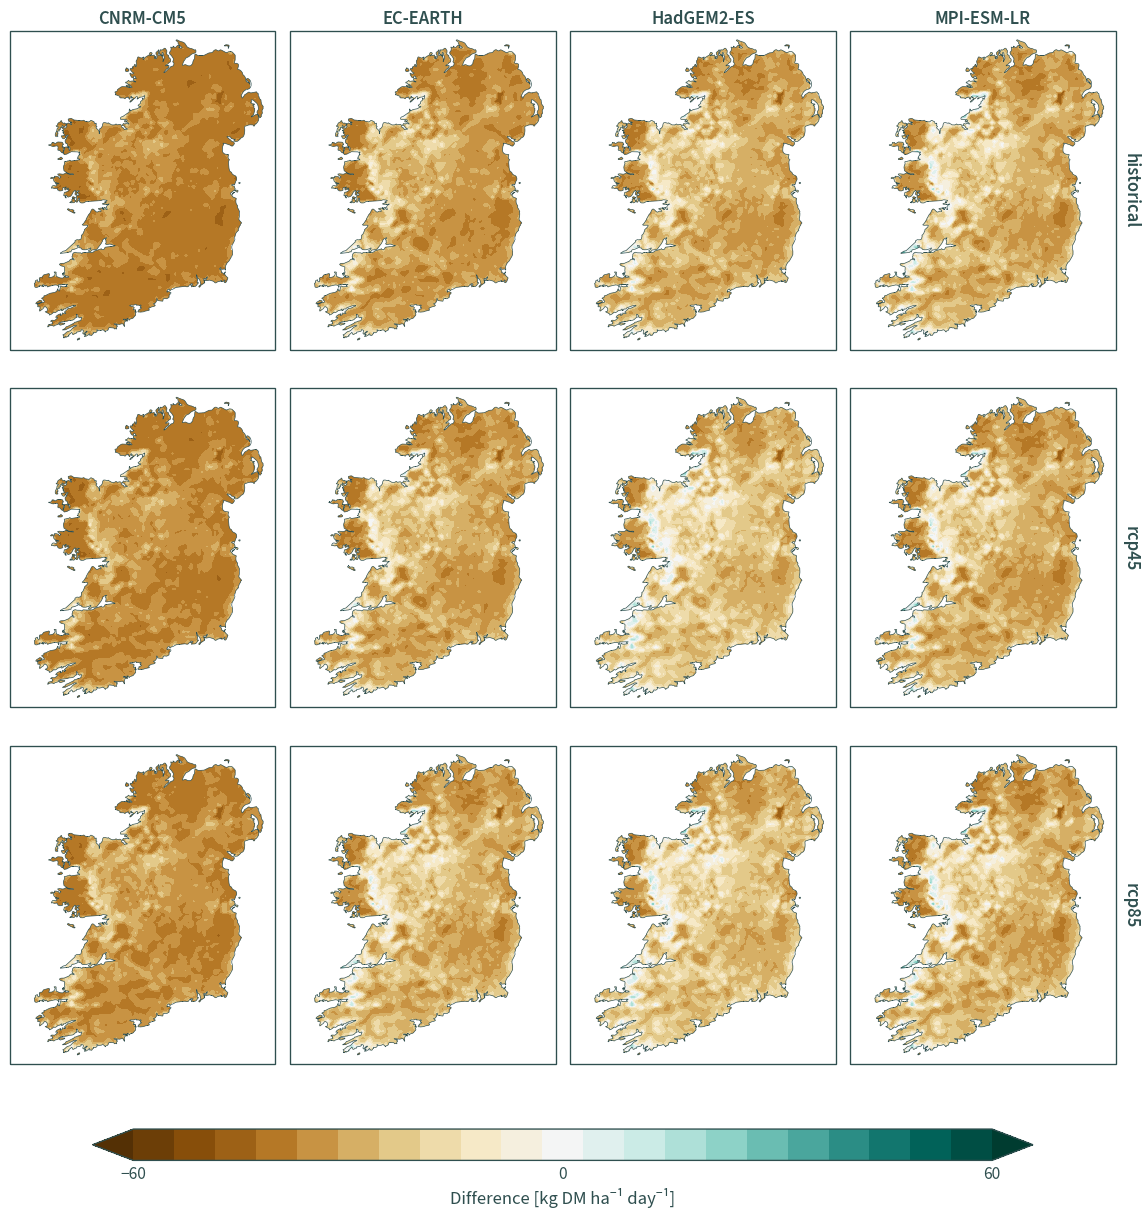

In [46]:
data_plot(
    data_county_mam,
    "gro_diff_2018",
    cstats.colorbar_levels(60),
    cstats.colorbar_ticks(60),
)

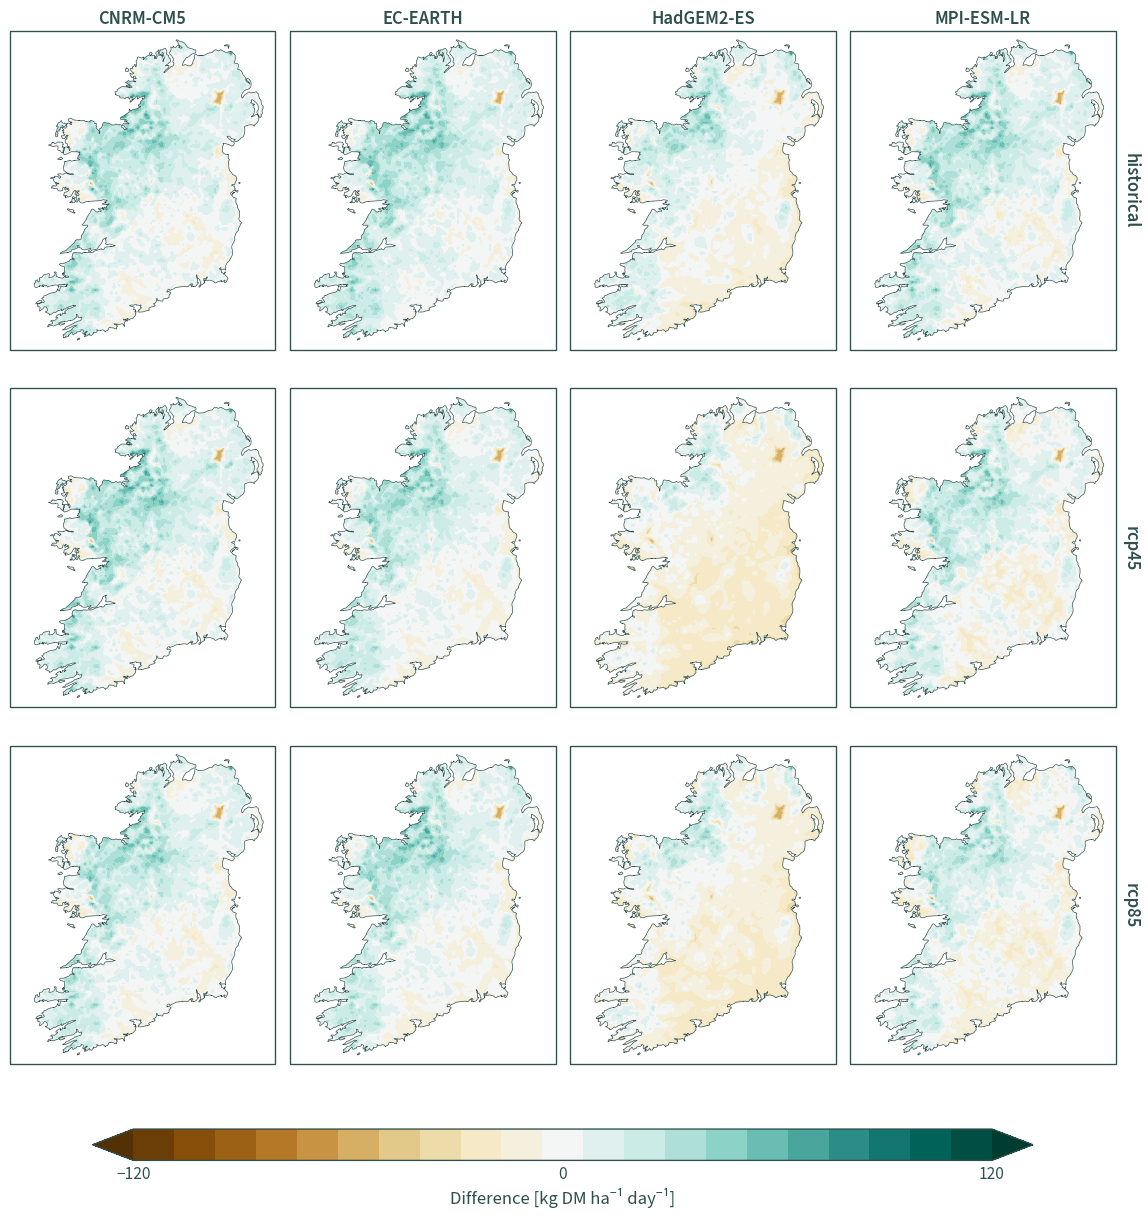

In [47]:
data_plot(
    data_county_jja,
    "gro_diff_2018",
    cstats.colorbar_levels(120),
    cstats.colorbar_ticks(120),
)